In [7]:
import os 
import os.path as osp
import numpy as np
import pandas as pd
import cv2
from glob import glob 
import matplotlib.pyplot as plt
from io import BytesIO

data_path =  "/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/Data/"

### Creating Train And Test Data 

In [8]:
def display_images(rgb,depth, columns=2, width=15, height=17, max_images=10):
    plt.figure(figsize=(width, height))
    if rgb.shape[0] > max_images:
        print(f"Showing {max_images} images of {rgb.shape[0]}:")
        rgb   = rgb[0:max_images]
        depth = depth[0:max_images]  
    index = 0 
    for rgb_img,depth_img in zip(rgb,depth):
        if index>=max_images:
            break
        plt.subplot(int(max_images/columns) , columns, index + 1)
        plt.title("RGB image")
        plt.tight_layout()
        plt.imshow(rgb_img)
        plt.subplot(int(max_images/columns) , columns, index + 2)
        plt.title("DEPTH Image")
        plt.tight_layout()
        plt.imshow(depth_img,cmap='gray')
        index += 2

In [10]:
def read_rgbimage(x):
    image_path = osp.join(data_path,x['RGB_images'])
    img = cv2.imread(image_path)
    return img.shape[:2]

def read_depthimage(x):
    image_path = osp.join(data_path,x['Depth_images'])
    img = cv2.imread(image_path)
    return img.shape[:2]
    
train_df  = pd.read_csv('../Data/data/nyu2_train.csv')
train_df.columns = ['RGB_images','Depth_images']

In [3]:

print("Train Images :",train_df.shape[0])
test_df = pd.read_csv('../Data/data/nyu2_test.csv')
test_df.columns = ['RGB_images','Depth_images']
print("Test Images :",test_df.shape[0])

Train Images : 50687
Test Images : 653


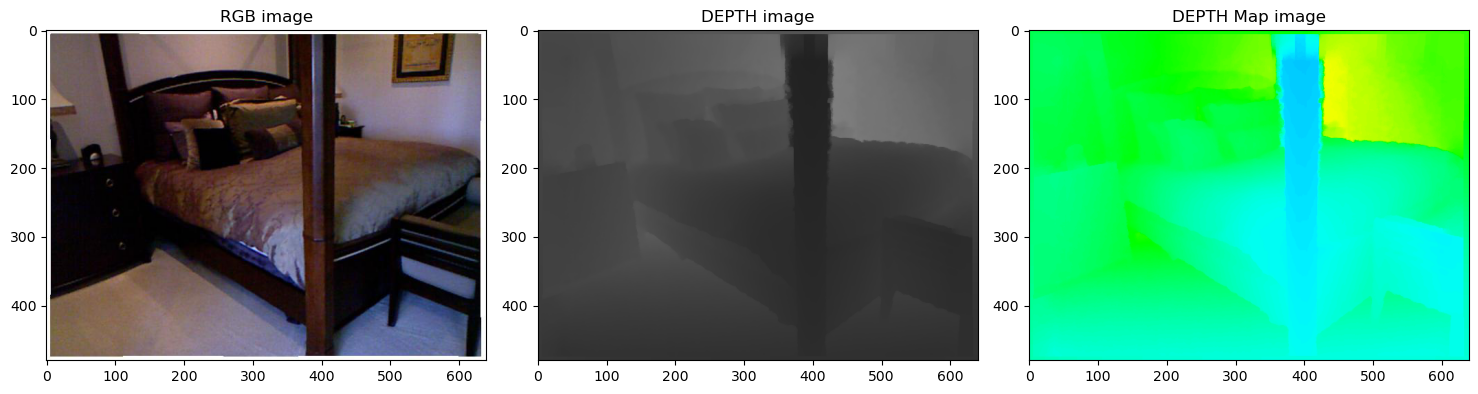

In [4]:
def get_depth_image(rgb_path,depth_path):
    rgb_image = cv2.imread(rgb_path)
    rgb_image = cv2.cvtColor(rgb_image,cv2.COLOR_BGR2RGB)
    depth_image = cv2.imread(depth_path)

    depth_colormap = cv2.applyColorMap(depth_image, cv2.COLORMAP_HSV)
    # rgb_depth_image = np.hstack((rgb_image, depth_colormap))
    return rgb_image,depth_image, depth_colormap

plt.figure(figsize=(15,17))
file_path = np.random.choice(train_df['RGB_images'],1)[0]
image_path = osp.join(data_path,file_path)
depth_path = osp.join(data_path,file_path.replace('jpg','png'))
rgb , depth , depth_map= get_depth_image(image_path,depth_path)

plt.subplot(1,3,1)
plt.title("RGB image")
plt.tight_layout()
plt.imshow(rgb)

plt.subplot(1,3,2)
plt.title("DEPTH image")
plt.tight_layout()
plt.imshow(depth)

plt.subplot(1,3,3)
plt.title("DEPTH Map image")
plt.tight_layout()
plt.imshow(depth_map)

    

### Validadtion Images 

In [5]:
val_path = osp.join(data_path,'data/val_data')

rgb = np.load(osp.join(val_path,'eigen_test_rgb.npy'))
depth = np.load(osp.join(val_path,'eigen_test_depth.npy'))
crop = np.load(osp.join(val_path,'eigen_test_crop.npy'))

Showing 2 images of 654:


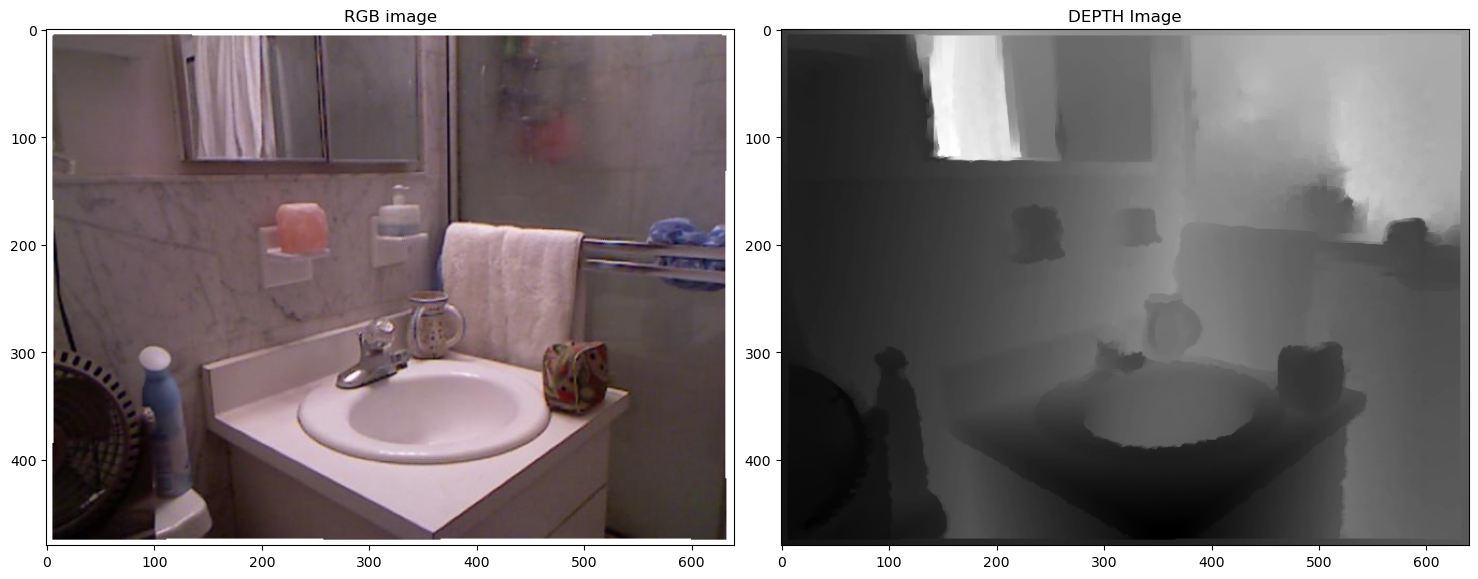

In [6]:
display_images(rgb,depth,max_images=2)


### Creating Train and Test Data set 

In [7]:
import pandas as pd
import numpy as np
import torch as th
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from io import BytesIO
import random
import albumentations  as album
from torchvision import transforms

device = "cuda" if th.cuda.is_available() else "cpu"
print("CUDA :",th.cuda.is_available())

# define the input image dimensions
INPUT_IMAGE_WIDTH = 640
INPUT_IMAGE_HEIGHT = 480


CUDA : True


In [8]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

def get_training_augmentation():
    print("Applying Transformation")
    train_transform = [    
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
                album.ChannelShuffle(p=1)
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        print("image shaep",image.shape)
        image = self.to_tensor(image)

        depth = np.expand_dims(depth,axis=-1)
        depth = self.to_tensor(depth).float() * 1000
        # depth = depth.resize((320, 240))
        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        if isinstance(pic, np.ndarray):
            img = th.from_numpy(np.transpose(pic,(2, 0, 1)))
            return img.float().div(255)

def pre_process():
    return transforms.Compose([ToTensor()])


In [12]:
class DatasetLoader(Dataset):
    def __init__(self, rgb_files ,depth_files, transform=None,process_image= None):
        self.rgb_data = rgb_files
        self.depth_data = depth_files
        self.transform = transform
        self.pre_process = process_image

    def __len__(self):
        return len(self.rgb_data) # return the number of total samples contained in the dataset

    def __getitem__(self, index):
        rgb = self.rgb_data[index]
        depth = self.depth_data[index]

        rgb_image = cv2.imread(rgb)
        rgb_image = cv2.cvtColor(rgb_image,cv2.COLOR_BGR2RGB)
        depth_image = cv2.imread(depth,cv2.IMREAD_GRAYSCALE)
        
        if self.transform: 
            sample = self.transform(image=rgb_image, mask=depth_image)
            rgb_image , depth_image  = sample['image'], sample['mask']

        if self.pre_process:
            sample = self.pre_process({'image':rgb_image,'depth':depth_image})
            rgb_image , depth_image  = sample['image'], sample['depth']
            # sample = self.pre_process(image=rgb_image,mask=depth_image)
            # rgb_image , depth_image = sample['image'],sample['mask']
            # rgb_image = rgb_image.float().div(255)  
        return rgb_image,depth_image
        
        
rgb_files = [osp.join(data_path,filename) for filename in train_df['RGB_images'].to_list()]
depth_files = [osp.join(data_path,filename) for filename in train_df['Depth_images'].to_list()]

val_rgb_files = [osp.join(data_path,filename) for filename in test_df['RGB_images'].to_list()]
val_depth_files = [osp.join(data_path,filename) for filename in test_df['Depth_images'].to_list()]

Applying Transformation
50687


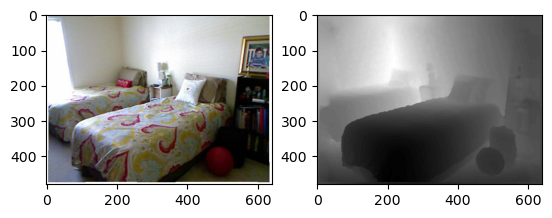

In [10]:
training_dataset = DatasetLoader(rgb_files,depth_files,transform=get_training_augmentation())
print(len(training_dataset))

random_idx = random.randint(0, len(training_dataset)-1)
image, depth = training_dataset[random_idx]

plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(depth,cmap='gray')

In [15]:
training_dataset = DatasetLoader(rgb_files,depth_files,transform=get_training_augmentation(),process_image=pre_process())
test_dataset = DatasetLoader(val_rgb_files,val_depth_files,transform=None,process_image=pre_process())

Applying Transformation
